In [1]:
import functools

from qdrant_client import QdrantClient

from langchain_groq import ChatGroq
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

import torch
from transformers import AutoModel
from FlagEmbedding import BGEM3FlagModel

from RAGModule.retrieve import retrieve_relevant_chunks

from GraphModule.chains import query_analyzer_chain, rewriter_chain, responder_chain
from GraphModule.pydantic_models import State
from GraphModule.nodes import *
from GraphModule.routes import *

from llm_compiler.utils import *
from llm_compiler.runnables import *
from llm_compiler.prompts import llm_compiler_prompt, joiner_prompt
from llm_compiler.pydantic_models import JoinOutputs

torch.set_grad_enabled(False)

from dotenv import load_dotenv
load_dotenv()

/opt/homebrew/Caskroom/miniconda/base/envs/chatbot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(device)

mps


In [3]:
client = QdrantClient("http://localhost:6333")
llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)
bge_m3 = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)
jina_v3 = AutoModel.from_pretrained("jinaai/jina-embeddings-v3", trust_remote_code=True).to(device)

Fetching 30 files: 100%|██████████| 30/30 [00:00<00:00, 328535.56it/s]
/opt/homebrew/Caskroom/miniconda/base/envs/chatbot/lib/python3.11/site-packages/FlagEmbedding/BGE_M3/modeling.py:335: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on 

In [4]:
retrieve_relevant_chunks = functools.partial(retrieve_relevant_chunks, jina_embedding = jina_v3, bge_embedding = bge_m3, client = client)

@tool
def retrieve_chunks(query: str) -> str:
    """retrieve_chunks(query="the search query") - This tool retrieves relevant information from a vector store containing insomnia-related data based on the given query"""
    relevant_chunks = retrieve_relevant_chunks(query=query)
    relevant_chunks = format_chunks(relevant_chunks[:3])
    return relevant_chunks
tools = [retrieve_chunks]

In [5]:
planner = create_planner(llm, tools, llm_compiler_prompt)

In [6]:
query = "Tell me some effects of caffeine"

for task in planner.stream([HumanMessage(content=query)]):
    print(task['tool'], task['args'])

name='retrieve_chunks' description='retrieve_chunks(query="the search query") - This tool retrieves relevant information from a vector store containing insomnia-related data based on the given query' args_schema=<class 'langchain_core.utils.pydantic.retrieve_chunks'> func=<function retrieve_chunks at 0x3d5896ac0> {'query': 'caffeine effects'}
join ()


In [7]:
runnable = joiner_prompt | llm.with_structured_output(JoinOutputs)
joiner_chain = select_recent_messages | runnable

In [8]:
@as_runnable
def plan_and_schedule(state: State):
    messages = state["llm_compiler_messages"]
    tasks = planner.stream(messages)
    # Begin executing the planner immediately
    try:
        tasks = itertools.chain([next(tasks)], tasks)
    except StopIteration:
        # Handle the case where tasks is empty.
        tasks = iter([])
    scheduled_tasks = schedule_tasks.invoke(
        {
            "messages": messages,
            "tasks": tasks,
        }
    )
    return {"llm_compiler_messages": scheduled_tasks}


def joiner(state: State):
    join_outputs: JoinOutputs = joiner_chain.invoke({"llm_compiler_messages": state["llm_compiler_messages"]})
    join_outputs.should_replan = False ### Temporary not using Replan

    if join_outputs.should_replan:
        return {"llm_compiler_messages":[AIMessage(content = f"Thought: {join_outputs.thought}")] +  [SystemMessage(content = join_outputs.replan_analysis)]}
    else:
        messages = state["llm_compiler_messages"]
        documents = ''
        for msg in messages[::-1]:
            if isinstance(msg, HumanMessage):
                break
            if msg.name == 'join':
                continue
            documents += msg.content + '\n\n'
        
        return {"documents": documents}

In [9]:
tool_messages = plan_and_schedule.invoke({"llm_compiler_messages": [HumanMessage(content=query)]})

Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


In [10]:
tool_messages

{'llm_compiler_messages': [FunctionMessage(content='---Begin Chunk---\nSource: ./Data/extracted/TÁC HẠI/ijerph-18-12389.md\ndoc_id:78db921d-6545-46d7-b345-ddfb38898886\nTitle: Effects of Caffeine and Caffeinated Beverages in Children, Adolescents and Young Adults: Short Review\n\nContent:\n## Keywords\n\ncaffeine; energy drink; alcohol; children; young adults; side effects\n\n## 1. Introduction\n\nCaffeine is a compound of many plants—a special psychostimulant, according to some data—and it is one of the most frequently used psychoactive substances in the world. After consumption, it is absorbed quickly.\n\nThe potential cellular effects of caffeine might be explained by three mechanisms:\n- The antagonism of adenosine receptors (especially in the central nervous system/CNS);\n- mobilization of the intracellular calcium storage (from the ER); and\n- inhibition of phosphodiesterases.\n\nNowadays, the most well-recognized mechanism is that caffeine acts in the CNS as a competitor of aden

In [10]:
graph_builder = StateGraph(State)

graph_builder.add_node("query_analyzer", query_analyzer)
graph_builder.add_node("rewriter", rewriter)
graph_builder.add_node("plan_and_schedule", plan_and_schedule)
graph_builder.add_node("joiner", joiner)
graph_builder.add_node("ask_human", ask_human)
graph_builder.add_node("responder", generate_response)

graph_builder.add_edge(START, "query_analyzer")
graph_builder.add_conditional_edges("query_analyzer", query_analyzer_route, {"rewriter": "rewriter", "responder": "responder"})
graph_builder.add_conditional_edges("rewriter", rewriter_route, {"ask_human": "ask_human", "llm_compiler": "plan_and_schedule"})
graph_builder.add_conditional_edges("joiner", compiler_route, {"plan_and_schedule": "plan_and_schedule", "responder": "responder"})
graph_builder.add_edge("ask_human", "rewriter")
graph_builder.add_edge("plan_and_schedule", "joiner")
graph_builder.add_edge("responder", END)

In [11]:
graph = graph_builder.compile(checkpointer=MemorySaver(), interrupt_before=["ask_human", "rewriter", "plan_and_schedule", "joiner", "responder"])

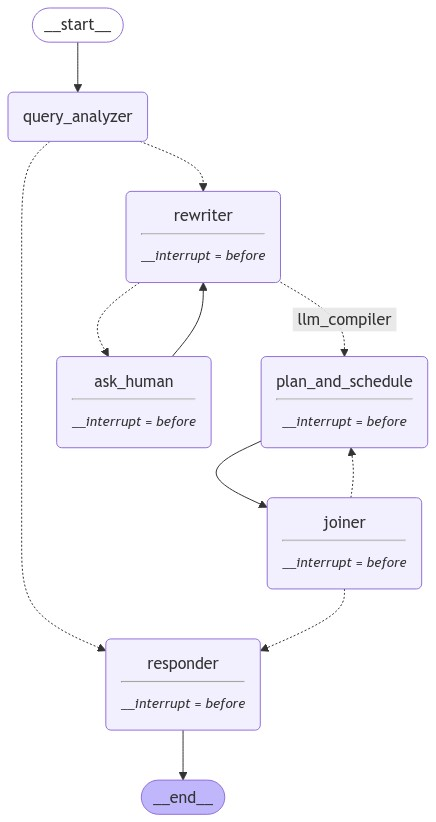

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
config = {"configurable": {"thread_id": 1}}

In [14]:
query = "Tell me some bad effects of insomnia"

for event in graph.stream({"messages": [HumanMessage(content=query)]}, config=config, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='Tell me some bad effects of insomnia', additional_kwargs={}, response_metadata={})], 'llm_compiler_messages': []}
{'messages': [HumanMessage(content='Tell me some bad effects of insomnia', additional_kwargs={}, response_metadata={})], 'query_analysis': QueryAnalysis(route='retrieve'), 'llm_compiler_messages': []}


In [15]:
graph.get_state(config).values, graph.get_state(config).next

({'messages': [HumanMessage(content='Tell me some bad effects of insomnia', additional_kwargs={}, response_metadata={})],
  'query_analysis': QueryAnalysis(route='retrieve'),
  'llm_compiler_messages': []},
 ('rewriter',))

In [16]:
for event in graph.stream(None, config=config, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='Tell me some bad effects of insomnia', additional_kwargs={}, response_metadata={})], 'query_analysis': QueryAnalysis(route='retrieve'), 'llm_compiler_messages': []}
{'messages': [HumanMessage(content='Tell me some bad effects of insomnia', additional_kwargs={}, response_metadata={})], 'rewriter_response': RewriterResponse(response="What are some negative effects of insomnia on a person's health?", need_clarification=False), 'query_analysis': QueryAnalysis(route='retrieve'), 'llm_compiler_messages': [HumanMessage(content="What are some negative effects of insomnia on a person's health?", additional_kwargs={}, response_metadata={})]}


In [17]:
graph.get_state(config).values, graph.get_state(config).next

({'messages': [HumanMessage(content='Tell me some bad effects of insomnia', additional_kwargs={}, response_metadata={})],
  'rewriter_response': RewriterResponse(response="What are some negative effects of insomnia on a person's health?", need_clarification=False),
  'query_analysis': QueryAnalysis(route='retrieve'),
  'llm_compiler_messages': [HumanMessage(content="What are some negative effects of insomnia on a person's health?", additional_kwargs={}, response_metadata={})]},
 ('plan_and_schedule',))

In [18]:
for event in graph.stream(None, config=config, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='Tell me some bad effects of insomnia', additional_kwargs={}, response_metadata={})], 'rewriter_response': RewriterResponse(response="What are some negative effects of insomnia on a person's health?", need_clarification=False), 'query_analysis': QueryAnalysis(route='retrieve'), 'llm_compiler_messages': [HumanMessage(content="What are some negative effects of insomnia on a person's health?", additional_kwargs={}, response_metadata={})]}


Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


{'messages': [HumanMessage(content='Tell me some bad effects of insomnia', additional_kwargs={}, response_metadata={})], 'rewriter_response': RewriterResponse(response="What are some negative effects of insomnia on a person's health?", need_clarification=False), 'query_analysis': QueryAnalysis(route='retrieve'), 'llm_compiler_messages': [HumanMessage(content="What are some negative effects of insomnia on a person's health?", additional_kwargs={}, response_metadata={}), FunctionMessage(content='---Begin Chunk---\nSource: ./Data/extracted/TÁC HẠI/healthcare-07-00001-v2.md\ndoc_id:66625443-a731-45cd-91ec-9eddb693eb35\nTitle: The Global Problem of Insufficient Sleep and Its Serious Public Health Implications\n\nContent:\n2.2. All-Cause Mortality\nEpidemiological evidence suggests that sleep duration and poor sleep are associated with premature mortality, as well as with an extensive variety of adverse health outcomes. The Sleep Heart Study was done to determine the association between insu

In [19]:
graph.get_state(config).values, graph.get_state(config).next

({'messages': [HumanMessage(content='Tell me some bad effects of insomnia', additional_kwargs={}, response_metadata={})],
  'rewriter_response': RewriterResponse(response="What are some negative effects of insomnia on a person's health?", need_clarification=False),
  'query_analysis': QueryAnalysis(route='retrieve'),
  'llm_compiler_messages': [HumanMessage(content="What are some negative effects of insomnia on a person's health?", additional_kwargs={}, response_metadata={}),
   FunctionMessage(content='---Begin Chunk---\nSource: ./Data/extracted/TÁC HẠI/healthcare-07-00001-v2.md\ndoc_id:66625443-a731-45cd-91ec-9eddb693eb35\nTitle: The Global Problem of Insufficient Sleep and Its Serious Public Health Implications\n\nContent:\n2.2. All-Cause Mortality\nEpidemiological evidence suggests that sleep duration and poor sleep are associated with premature mortality, as well as with an extensive variety of adverse health outcomes. The Sleep Heart Study was done to determine the association be

In [20]:
for event in graph.stream(None, config=config, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='Tell me some bad effects of insomnia', additional_kwargs={}, response_metadata={})], 'rewriter_response': RewriterResponse(response="What are some negative effects of insomnia on a person's health?", need_clarification=False), 'query_analysis': QueryAnalysis(route='retrieve'), 'llm_compiler_messages': [HumanMessage(content="What are some negative effects of insomnia on a person's health?", additional_kwargs={}, response_metadata={}), FunctionMessage(content='---Begin Chunk---\nSource: ./Data/extracted/TÁC HẠI/healthcare-07-00001-v2.md\ndoc_id:66625443-a731-45cd-91ec-9eddb693eb35\nTitle: The Global Problem of Insufficient Sleep and Its Serious Public Health Implications\n\nContent:\n2.2. All-Cause Mortality\nEpidemiological evidence suggests that sleep duration and poor sleep are associated with premature mortality, as well as with an extensive variety of adverse health outcomes. The Sleep Heart Study was done to determine the association between insu

In [21]:
graph.get_state(config).values, graph.get_state(config).next

({'messages': [HumanMessage(content='Tell me some bad effects of insomnia', additional_kwargs={}, response_metadata={})],
  'rewriter_response': RewriterResponse(response="What are some negative effects of insomnia on a person's health?", need_clarification=False),
  'query_analysis': QueryAnalysis(route='retrieve'),
  'documents': '---Begin Chunk---\nSource: ./Data/extracted/TÁC HẠI/healthcare-07-00001-v2.md\ndoc_id:66625443-a731-45cd-91ec-9eddb693eb35\nTitle: The Global Problem of Insufficient Sleep and Its Serious Public Health Implications\n\nContent:\n2.2. All-Cause Mortality\nEpidemiological evidence suggests that sleep duration and poor sleep are associated with premature mortality, as well as with an extensive variety of adverse health outcomes. The Sleep Heart Study was done to determine the association between insufficient sleep conditions, including insomnia or poor-quality sleep and objectively measured short duration sleep, and the incidence of cardiovascular disease (CVD)

In [22]:
for event in graph.stream(None, config=config, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='Tell me some bad effects of insomnia', additional_kwargs={}, response_metadata={})], 'rewriter_response': RewriterResponse(response="What are some negative effects of insomnia on a person's health?", need_clarification=False), 'query_analysis': QueryAnalysis(route='retrieve'), 'documents': '---Begin Chunk---\nSource: ./Data/extracted/TÁC HẠI/healthcare-07-00001-v2.md\ndoc_id:66625443-a731-45cd-91ec-9eddb693eb35\nTitle: The Global Problem of Insufficient Sleep and Its Serious Public Health Implications\n\nContent:\n2.2. All-Cause Mortality\nEpidemiological evidence suggests that sleep duration and poor sleep are associated with premature mortality, as well as with an extensive variety of adverse health outcomes. The Sleep Heart Study was done to determine the association between insufficient sleep conditions, including insomnia or poor-quality sleep and objectively measured short duration sleep, and the incidence of cardiovascular disease (CVD) and mo

In [ ]:
query = "Tell me about ..."
async for event in graph.astream_events({"messages": [HumanMessage(content=query)]}, config = config, version="v2"):
    if event['event'] == 'on_chat_model_stream' and event['metadata'].get('langgraph_node', '') == 'responder':
        print(event['data']['chunk'].content, end='')

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Tell me about ...', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '20bf0769-1142-4a8c-9b12-ba67896c6428', 'metadata': {'thread_id': 0}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Tell me about ...', additional_kwargs={}, response_metadata={})]}}, 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden', 'langsmith:hidden'], 'run_id': '972fb239-d169-49da-a38a-fbd972e0be4b', 'metadata': {'thread_id': 0, 'langgraph_step': 0, 'langgraph_node': '__start__', 'langgraph_triggers': ['__start__'], 'langgraph_path': ('__pregel_pull', '__start__'), 'langgraph_checkpoint_ns': '__start__:6f8f8d9a-68a6-b6ca-0aec-2cc0df017be7'}, 'parent_ids': ['20bf0769-1142-4a8c-9b12-ba67896c6428']}
{'event': 'on_chain_end', 'data': {'output': {'messages': [HumanMessage(content='Tell me about ...', additional_kwargs={}, respons

In [16]:
graph.get_state(config).next

('ask_human',)

In [17]:
event

{'event': 'on_chain_end',
 'data': {'output': {'messages': [HumanMessage(content='Tell me some common causes of insomnia in teenagers. Does caffeine one of them?', additional_kwargs={}, response_metadata={}),
    AIMessage(content="Insomnia in teenagers can be caused by a variety of factors. Some common causes include stress, anxiety, depression, irregular sleep schedules, and stimulating activities before bedtime. \n\nYes, caffeine is indeed one of the potential causes of insomnia in teenagers. Caffeine is a widely consumed stimulant that can interfere with sleep quality. Consuming caffeine in the afternoon or evening can disrupt sleep patterns and make it harder to fall asleep. This is because caffeine can stimulate the central nervous system and increase alertness, making it difficult to relax and fall asleep.\n\nIn fact, studies have shown that high caffeine intake is associated with shorter sleep duration, increased wake after sleep onset, and more difficulty falling or staying as

In [13]:
is_first = True
while True:
    query = input()
    HumanMessage(query).pretty_print()

    if query == "q":
        break

    try:
        if graph.get_state(config).next[0] == 'ask_human':
            is_first = False
            graph.update_state(config, {"messages": [HumanMessage(content = query)]}, as_node="ask_human")
    except:
        pass
        
        
    
    for event in graph.stream({"messages": [HumanMessage(content = query)]} if is_first else None, config=config, stream_mode="values"):
        pass
    
    print(graph.get_state(config).values['messages'][-1].pretty_print())

================================ Human Message =================================

Tell me bad effects of caffeine


Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


================================== Ai Message ==================================

Caffeine can have several negative effects, especially when consumed in excess or by certain individuals. Some of the potential side effects of caffeine include:

1. **Increased heart rate and blood pressure**: Caffeine can cause an increase in heart rate and blood pressure, which can be problematic for people with pre-existing heart conditions [doc_id:78db921d-6545-46d7-b345-ddfb38898886].
2. **Sleep disturbances**: Consuming caffeine in large amounts or too close to bedtime can disrupt sleep patterns and reduce the quality of sleep [doc_id:78db921d-6545-46d7-b345-ddfb38898886].
3. **Anxiety and jitteriness**: Caffeine can cause feelings of anxiety, jitteriness, and an increased sense of alertness, which can be uncomfortable for some people [doc_id:78db921d-6545-46d7-b345-ddfb38898886].
4. **Addiction**: Caffeine is a mildly addictive substance, and regular consumption can lead to physical dependence [do